# Libraries Setup

In [135]:
# Install required libraries
!pip install numpy pandas scikit-learn matplotlib tensorflow keras

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
from sklearn.metrics import classification_report, make_scorer, confusion_matrix, roc_curve, auc
from sklearn.decomposition import TruncatedSVD
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.losses import BinaryCrossentropy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix

# Data Loading and Preprocessing

## Training and Test Data

In [2]:
ROOT ='data/'

In [3]:
# Load the dataset
train_url = ROOT + 'UNSW_NB15_training-set.parquet'
test_url = ROOT + 'UNSW_NB15_testing-set.parquet'

train_data = pd.read_parquet(train_url)
test_data = pd.read_parquet(test_url)

In [4]:
# Inspect the dataset
print(train_data.head())

        dur proto service state  spkts  dpkts  sbytes  dbytes          rate  \
0  0.000011   udp       -   INT      2      0     496       0   90909.09375   
1  0.000008   udp       -   INT      2      0    1762       0  125000.00000   
2  0.000005   udp       -   INT      2      0    1068       0  200000.00000   
3  0.000006   udp       -   INT      2      0     900       0  166666.65625   
4  0.000010   udp       -   INT      2      0    2126       0  100000.00000   

         sload  ...  trans_depth  response_body_len  ct_src_dport_ltm  \
0  180363632.0  ...            0                  0                 1   
1  881000000.0  ...            0                  0                 1   
2  854400000.0  ...            0                  0                 1   
3  600000000.0  ...            0                  0                 2   
4  850400000.0  ...            0                  0                 2   

   ct_dst_sport_ltm  is_ftp_login  ct_ftp_cmd  ct_flw_http_mthd  \
0                 1

In [5]:
train_data

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sload,...,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,-,INT,2,0,496,0,90909.093750,1.803636e+08,...,0,0,1,1,0,0,0,0,Normal,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.000000,8.810000e+08,...,0,0,1,1,0,0,0,0,Normal,0
2,0.000005,udp,-,INT,2,0,1068,0,200000.000000,8.544000e+08,...,0,0,1,1,0,0,0,0,Normal,0
3,0.000006,udp,-,INT,2,0,900,0,166666.656250,6.000000e+08,...,0,0,2,1,0,0,0,0,Normal,0
4,0.000010,udp,-,INT,2,0,2126,0,100000.000000,8.504000e+08,...,0,0,2,1,0,0,0,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000005,udp,-,INT,2,0,104,0,200000.000000,8.320000e+07,...,0,0,1,1,0,0,0,0,Normal,0
82328,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,1.241044e+05,...,0,0,1,1,0,0,0,0,Normal,0
82329,0.000000,arp,-,INT,1,0,46,0,0.000000,0.000000e+00,...,0,0,1,1,0,0,0,1,Normal,0
82330,0.000000,arp,-,INT,1,0,46,0,0.000000,0.000000e+00,...,0,0,1,1,0,0,0,1,Normal,0


In [6]:
test_data

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sload,...,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,attack_cat,label
0,0.121478,tcp,-,FIN,6,4,258,172,74.087486,1.415894e+04,...,0,0,1,1,0,0,0,0,Normal,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473373,8.395112e+03,...,0,0,1,1,0,0,0,0,Normal,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,1.572272e+03,...,0,0,1,1,0,0,0,0,Normal,0
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,2.740179e+03,...,0,0,1,1,1,1,0,0,Normal,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373825,8.561499e+03,...,0,0,2,1,0,0,0,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,0.000009,udp,dns,INT,2,0,114,0,111111.109375,5.066666e+07,...,0,0,24,13,0,0,0,0,Generic,1
175337,0.505762,tcp,-,FIN,10,8,620,354,33.612648,8.826286e+03,...,0,0,1,1,0,0,0,0,Shellcode,1
175338,0.000009,udp,dns,INT,2,0,114,0,111111.109375,5.066666e+07,...,0,0,3,3,0,0,0,0,Generic,1
175339,0.000009,udp,dns,INT,2,0,114,0,111111.109375,5.066666e+07,...,0,0,30,14,0,0,0,0,Generic,1


In [7]:
# Split into features and labels
X_train = train_data.drop(columns=['label'])
y_train = train_data['label']
X_test = test_data.drop(columns=['label'])
y_test = test_data['label']

In [8]:
# Identify numeric and categorical columns
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

In [9]:
# Define the preprocessing pipeline for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [10]:
# Fit the preprocessing pipeline on X_train and transform both X_train and X_test
X_train_scaled = preprocessor.fit_transform(X_train)

In [11]:
X_test_scaled = preprocessor.transform(X_test)

## Global Data

In [12]:
# Combine train and test data into a single DataFrame
data = pd.concat([train_data, test_data])

In [13]:
# Get features and target variable (ground truth)
X = data.drop(columns=['label'])
y = data['label']

In [14]:
# Identify numeric and categorical columns
numeric_features_all = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features_all = X.select_dtypes(exclude=[np.number]).columns.tolist()

In [15]:
preprocessor_all = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_all),
        ('cat', OneHotEncoder(), categorical_features_all)
    ])

In [16]:
# Preprocess features
X_scaled = preprocessor_all.fit_transform(X)

In [17]:
X_scaled

<257673x198 sparse matrix of type '<class 'numpy.float64'>'
	with 9018555 stored elements in Compressed Sparse Row format>

## Data Distribution (2D SVD)

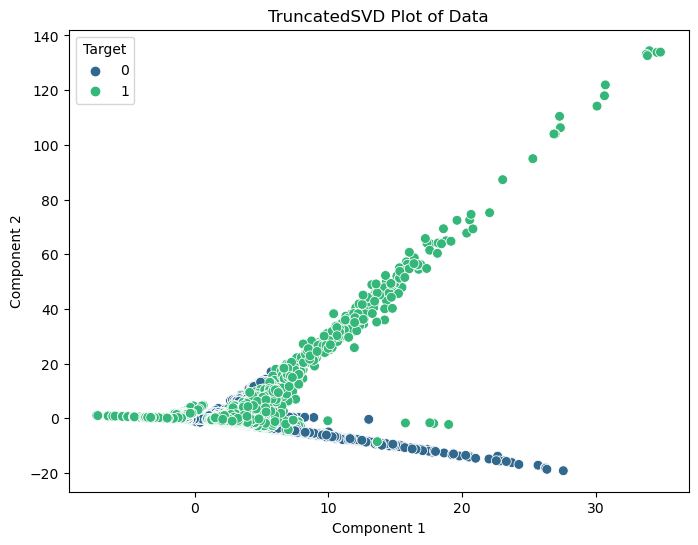

In [18]:
# Initialize TruncatedSVD with 2 components
svd = TruncatedSVD(n_components=2)

# Fit and transform the scaled data
X_svd = svd.fit_transform(X_scaled)

# Plotting the SVD-transformed data
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_svd[:, 0], y=X_svd[:, 1], hue=y, palette='viridis', s=50)
plt.title('TruncatedSVD Plot of Data')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Target', loc='best')
plt.show()

# Anomaly Detection Models

## Isolation Forest

Isolation Forest stands as a formidable anomaly detection algorithm renowned for its efficiency and versatility. Anomaly detection is the backbone of data analysis to identify patterns or events that deviate significantly from the norm in a dataset. Isolation forest operates by isolating anomalies within a dataset through a process of recursive partitioning.

Unlike traditional methods that rely on proximity measures, Isolation Forest takes a unique approach by randomly selecting features and splitting them along random values until individual data points are isolated.
This “isolating” process is responsible for creating partitions or “trees” that aim to separate anomalies from normal observations.
Anomalies, being fewer in number and further from the norm, typically require fewer splits to isolate, making them easier to detect.

In [154]:
# Determine the fraction of outliers
outliers = len(data[data['label']==1])
total = len(data[data['label']==0]) + len(data[data['label']==1])
outlier_fraction = outliers/float(total)

In [155]:
outlier_fraction

0.6390774353541117

In [156]:
# Initialize the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.5, random_state=42)

# Convert combined data to csr_matrix
X_scaled_csr = X_scaled.toarray() if isinstance(X_scaled, csr_matrix) else X_scaled

# Fit the model to unlabeled data
iso_forest.fit(X_scaled_csr)

IsolationForest(contamination=0.5, random_state=42)

In [157]:
print(iso_forest.get_params())

{'bootstrap': False, 'contamination': 0.5, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100, 'n_jobs': None, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [158]:
# Predict anomalies
y_pred = iso_forest.predict(X_scaled)
y_pred = np.where(y_pred == 1, 0, 1)  # Convert to 0 (normal) and 1 (anomaly)

In [159]:
# Evaluate (Compare to ground truth)
print("Isolation Forest")
print(classification_report(y, y_pred))

Isolation Forest
              precision    recall  f1-score   support

           0       0.28      0.39      0.32     93000
           1       0.56      0.44      0.49    164673

    accuracy                           0.42    257673
   macro avg       0.42      0.41      0.41    257673
weighted avg       0.46      0.42      0.43    257673



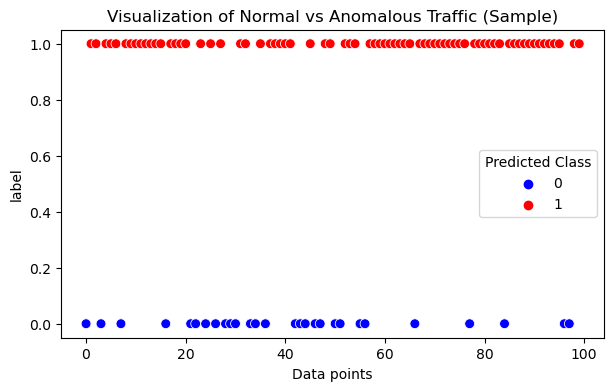

In [160]:
# Define the sample size
sample_size = 100
# Plot the graph
plt.figure(figsize=(7, 4))
sns.scatterplot(x=data.index[:sample_size], y=y_pred[:sample_size], hue=y_pred[:sample_size], palette={0: 'blue', 1: 'red'}, s=50)
plt.title('Visualization of Normal vs Anomalous Traffic (Sample)')
plt.xlabel('Data points')
plt.ylabel(y.name)
plt.legend(title='Predicted Class', loc='best')
plt.show()

In [161]:
# Get feature names post one-hot encoding
encoded_feature_names = list(preprocessor_all.named_transformers_['cat'].get_feature_names_out(categorical_features_all))
feature_names = numeric_features_all + encoded_feature_names

In [162]:
len(feature_names)

198

In [163]:
from sklearn.tree import export_text

# Access individual trees from the trained Isolation Forest
trees = iso_forest.estimators_

# Example: print the structure of the first tree
for i, tree in enumerate(trees):
    print(f"Tree {i}")
    try:
        print(export_text(tree, feature_names=feature_names))
    except ValueError as e:
        print(f"Error: {e}")
    break

Tree 0
|--- service_ftp-data <= 0.08
|   |--- proto_chaos <= 0.30
|   |   |--- service_http <= 0.69
|   |   |   |--- state_CON <= 1.00
|   |   |   |   |--- attack_cat_Analysis <= 0.54
|   |   |   |   |   |--- djit <= 27.46
|   |   |   |   |   |   |--- attack_cat_Exploits <= 0.10
|   |   |   |   |   |   |   |--- proto_st2 <= 0.50
|   |   |   |   |   |   |   |   |--- value: [0.50]
|   |   |   |   |   |   |   |--- proto_st2 >  0.50
|   |   |   |   |   |   |   |   |--- value: [0.46]
|   |   |   |   |   |   |--- attack_cat_Exploits >  0.10
|   |   |   |   |   |   |   |--- sinpkt <= -0.13
|   |   |   |   |   |   |   |   |--- value: [0.55]
|   |   |   |   |   |   |   |--- sinpkt >  -0.13
|   |   |   |   |   |   |   |   |--- value: [0.62]
|   |   |   |   |   |--- djit >  27.46
|   |   |   |   |   |   |--- value: [0.17]
|   |   |   |   |--- attack_cat_Analysis >  0.54
|   |   |   |   |   |--- value: [0.12]
|   |   |   |--- state_CON >  1.00
|   |   |   |   |--- dinpkt <= -0.09
|   |   |   |   |

## One-Class SVM

One-class SVM (Support Vector Machine) is an unsupervised learning algorithm used for anomaly detection. It learns the boundary of normal data in a high-dimensional space. Data points falling outside this boundary are considered anomalies. The method is particularly useful when the dataset has many more normal instances compared to anomalies. One-class SVM is effective in detecting outliers by focusing solely on the distribution of normal data. It can be applied to various fields, such as fraud detection, network security, and quality control.

In [18]:
# One-Class SVM
oc_svm = OneClassSVM(kernel='rbf', degree=3, gamma='auto', coef0=0.0, tol=0.001, nu=0.5, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
oc_svm.fit(X_scaled)

OneClassSVM(gamma='auto')

In [19]:
# Predict anomalies and compare to ground truth
y_pred_oc_svm = oc_svm.predict(X_scaled)
y_pred_oc_svm = np.where(y_pred_oc_svm == 1, 0, 1)  # Convert to 0 (normal) and 1 (anomaly)

In [20]:
# Evaluate
print("One-Class SVM")
print(classification_report(y, y_pred_oc_svm))

One-Class SVM
              precision    recall  f1-score   support

           0       0.35      0.49      0.41     93000
           1       0.63      0.49      0.55    164673

    accuracy                           0.49    257673
   macro avg       0.49      0.49      0.48    257673
weighted avg       0.53      0.49      0.50    257673



## DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is an unsupervised learning algorithm used for clustering and anomaly detection. It groups data points that are closely packed together while marking points in low-density regions as outliers. Unlike other clustering methods, DBSCAN doesn't require specifying the number of clusters beforehand. It is robust to noise and can discover clusters of arbitrary shapes. DBSCAN is effective for datasets with varying densities and is widely used in fields like geospatial analysis, image processing, and market segmentation.

In [167]:
pip install threadpoolctl==3.1.0

Note: you may need to restart the kernel to use updated packages.


In [19]:
# Take a random sample from the dataset
sample_size = 10000
data_sample = data.sample(n=sample_size, random_state=42)

In [20]:
# Split features and target
X_sample = data_sample.drop(columns='label')
y_sample = data_sample['label']

In [21]:
# Preprocess the data
X_sample_scaled = preprocessor_all.fit_transform(X_sample)

In [22]:
# DBSCAN
dbscan = DBSCAN(eps=3, min_samples=5)

In [23]:
# Compute clusters from data and predict labels
y_pred_dbscan = dbscan.fit_predict(X_sample_scaled)

In [24]:
# Convert to 0 (normal) and 1 (anomaly)
y_pred_dbscan = np.where(y_pred_dbscan == -1, 1, 0)

In [25]:
# Evaluate
print("DBSCAN")
print(classification_report(y_sample, y_pred_dbscan))

DBSCAN
              precision    recall  f1-score   support

           0       0.37      0.99      0.53      3659
           1       0.64      0.01      0.03      6341

    accuracy                           0.37     10000
   macro avg       0.50      0.50      0.28     10000
weighted avg       0.54      0.37      0.21     10000



# LSTM for Sequential Patterns

An LSTM neural network enables you to input sequence data into a network, and make predictions based on the individual time steps of the sequence data.

In [176]:
# Prepare the data for LSTM

# Convert sparse matrices to dense arrays for reshaping
X_train_dense = X_train_scaled.toarray()
X_test_dense = X_test_scaled.toarray()

# Reshape for LSTM
X_train_lstm = np.reshape(X_train_dense, (X_train_dense.shape[0], 1, X_train_dense.shape[1]))
X_test_lstm = np.reshape(X_test_dense, (X_test_dense.shape[0], 1, X_test_dense.shape[1]))

In [177]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Using sigmoid for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy')

In [178]:
# Train the model
history = model.fit(X_train_lstm, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/10
1030/1030 [==============================] - 13s 8ms/step - loss: 0.0686 - val_loss: 0.0080
Epoch 2/10
1030/1030 [==============================] - 8s 7ms/step - loss: 5.1119e-04 - val_loss: 0.0014
Epoch 3/10
1030/1030 [==============================] - 8s 7ms/step - loss: 1.3275e-04 - val_loss: 5.6723e-04
Epoch 4/10
1030/1030 [==============================] - 8s 7ms/step - loss: 5.2739e-05 - val_loss: 2.6605e-04
Epoch 5/10
1030/1030 [==============================] - 8s 7ms/step - loss: 2.4505e-05 - val_loss: 1.3361e-04
Epoch 6/10
1030/1030 [==============================] - 7s 7ms/step - loss: 1.2316e-05 - val_loss: 7.3509e-05
Epoch 7/10
1030/1030 [==============================] - 8s 7ms/step - loss: 6.4660e-06 - val_loss: 3.9317e-05
Epoch 8/10
1030/1030 [==============================] - 8s 8ms/step - loss: 3.4793e-06 - val_loss: 2.4000e-05
Epoch 9/10
1030/1030 [==============================] - 8s 8ms/step - loss: 1.9087e-06 - val_loss: 1.4620e-05
Epoch 10/10
1030/1030

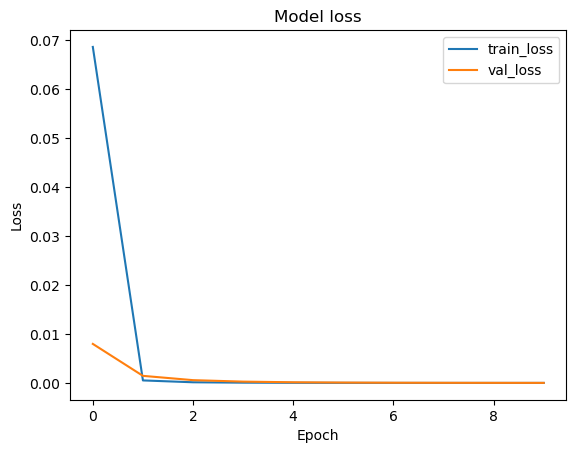

In [179]:
# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train_loss','val_loss'])
plt.show()

In [180]:
# Predict and evaluate
y_pred_lstm_prob = model.predict(X_test_lstm)
y_pred_lstm = np.where(y_pred_lstm_prob > 0.5, 1, 0)

5480/5480 [==============================] - 17s 3ms/step


In [181]:
print("LSTM")
print(classification_report(y_test, y_pred_lstm))

LSTM
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56000
           1       1.00      1.00      1.00    119341

    accuracy                           1.00    175341
   macro avg       1.00      1.00      1.00    175341
weighted avg       1.00      1.00      1.00    175341



In [182]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lstm)
print("Confusion Matrix")
print(cm)

Confusion Matrix
[[ 55834    166]
 [     2 119339]]


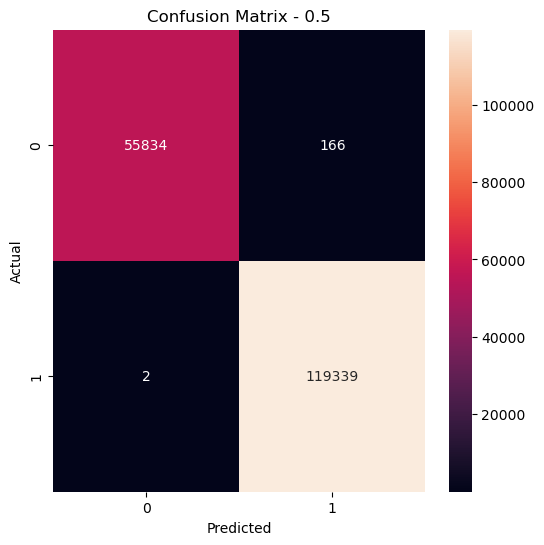

In [183]:
treshold = 0.5
plt.figure(figsize = (6,6))
sns.heatmap(cm, annot = True, fmt = 'g')
plt.title('Confusion Matrix - {}'.format(treshold))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

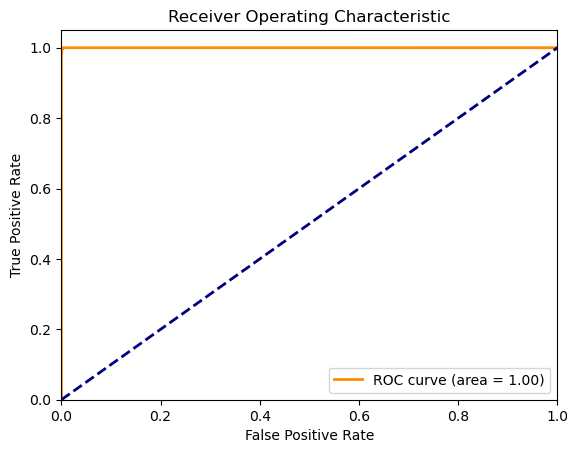

In [184]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_lstm_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Semi-Supervised Learning

Semi-supervised learning is a machine learning approach that uses both labeled and unlabeled data. It falls between supervised and unsupervised learning. By leveraging a small amount of labeled data along with a larger set of unlabeled data, it improves learning accuracy. This approach is useful when labeling data is expensive or time-consuming. Semi-supervised learning can enhance performance in various applications, including text classification, image recognition, and medical diagnosis. It balances the need for labeled data with the abundance of unlabeled data to build more robust models.

In [185]:
NUM_ITERATIONS = 5

In [186]:
# Initialize the model (using Isolation Forest)
model = IsolationForest(contamination=0.1, random_state=42)

In [190]:
# Iterative training

for _ in range(NUM_ITERATIONS):  # Number of iterations

    X_train_scaled_csr = X_train_scaled.toarray() if isinstance(X_train_scaled, csr_matrix) else X_train_scaled
    
    model.fit(X_train_scaled_csr)
    y_pred = model.predict(X_train_scaled_csr)
    high_confidence = np.where(y_pred == 1, True, False)
    
    # Add high-confidence predictions to the training set
    X_train_scaled_csr = np.concatenate([X_train_scaled_csr, X_train_scaled_csr[high_confidence]], axis=0)
    y_train = np.concatenate([y_train, y_pred[high_confidence]], axis=0)

In [191]:
# Final prediction on test set
y_pred = model.predict(X_test_scaled)
y_pred = np.where(y_pred == 1, 0, 1)  # Convert to 0 (normal) and 1 (anomaly)

In [192]:
# Evaluate
print("Semi-Supervised Learning")
print(classification_report(y_test, y_pred))

Semi-Supervised Learning
              precision    recall  f1-score   support

           0       0.31      0.84      0.45     56000
           1       0.58      0.10      0.17    119341

    accuracy                           0.34    175341
   macro avg       0.44      0.47      0.31    175341
weighted avg       0.49      0.34      0.26    175341



# Conclusion

In conclusion, this project demonstrates the effective use of advanced machine learning techniques for anomaly detection and data analysis. By leveraging a combination of unsupervised learning methods like Isolation Forest and clustering algorithms such as DBSCAN, alongside semi-supervised approaches, we have successfully identified anomalies and gained insights into our dataset (Network Traffic). The integration of preprocessing steps, feature engineering, and dimensionality reduction ensures that the models are robust and perform well across various applications. This comprehensive approach highlights the importance of combining different methodologies to achieve accurate and efficient results in anomaly detection and data-driven decision-making.